# Creating comet models

In [1]:
import os, sys
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/stella/')
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/scripts/')
import numpy as np
from utils import *
import models
import matplotlib.pyplot as plt
from astropy.table import Table
from glob import glob
from tqdm import tqdm
import wotan
import lightkurve as lk
import stella
import pandas as pd
import random
import batman 
import warnings
from sklearn.preprocessing import MinMaxScaler, RobustScaler

/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/azib/.lightkurve/cache. Please move all the files in the legacy directory /Users/azib/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


### Generate the models

In [2]:
files = glob('../data/eleanor/s0007/*.fits', recursive=True)
#files = glob('../data/kepler/Q0/*.fits',recursive=True)
random.shuffle(files)

### Create models

In [3]:
name = 'test'
folder = f'../models/{name}' 

In [4]:
def calculate_timestep(table):
    """
    Function: Calculates the median value of the time differences between data points in a given table. 
    Provides an estimate of the timestep (or time delta) between consecutive data points.

    Parameters:
    :table (array or pandas.DataFrame): The input table containing time-series data.

    Returns:
    :dt (float): The estimated time interval or timestep between consecutive data points."""

    try:
        dt = [ table[i+1][0] - table[i][0] for i in range(len(table)-1) ] # calculates difference between (ith+1) - (ith) point 
        dt.sort()
        return dt[int(len(dt)/2)] # median of them.
    except:
        return np.median(np.diff(table['time'])) ## change this to account for any time column names

    

def clean_data(table):
    """
    Function: Interpolating missing data points, ensuring equal time gaps between points. 
    Returns five numpy arrays: time, flux, quality, real, and flux_error. Real is 0 if data point interpolated, 1 otherwise.

    Parameters:
    :table (astropy.table.table): The input table containing time-series data.
    
    Returns:
    :time (numpy.ndarray): An array of timestamps for each data point, including the interpolated points.
    :flux (numpy.ndarray): An array of flux values for each data point, including the interpolated points.
    :quality (numpy.ndarray): An array indicating the quality of each data point, including the interpolated points.
    :real (numpy.ndarray): An array indicating whether each data point is real (1) or interpolated (0).
    :flux_error (numpy.ndarray): An array of flux error values for each data point, including the interpolated points."""


    time = []
    flux = []
    quality = []
    real = []
    flux_error = []
    timestep = calculate_timestep(table)


    ### this scale factor ensures that you can use any cadence of lightcurves. 48 cadences = 1 day.
    factor = ((1/48)/timestep)

    for row in table:
        ti, fi, qi, fei = row

        if len(time) > 0:
            steps = int(round( (ti - time[-1])/timestep * factor)) # (y2-y1)/(x2-x1)
            if steps > 1:
                fluxstep = (fi - flux[-1])/steps
                fluxerror_step = (fei - flux_error[-1])/steps

                # For small gaps, pretend interpolated data is real.
                if steps > 3:
                    set_real=0
                else:
                    set_real=1

                for _ in range(steps-1):
                    time.append(timestep + time[-1])
                    flux.append(fluxstep + flux[-1])
                    flux_error.append(fluxerror_step + flux_error[-1])

                    quality.append(0)
                    real.append(set_real)
        time.append(ti)
        flux.append(fi)
        quality.append(qi)
        real.append(1)
        flux_error.append(fei)

    return [np.array(x) for x in [time,flux,quality,real,flux_error]]

In [14]:
def scale_relative_to_baseline(flux):
    baseline = np.median(flux)  # or use a more sophisticated method to determine baseline
    scaled_flux = (flux - baseline) / baseline
    return (scaled_flux - np.min(scaled_flux)) / (np.max(scaled_flux) - np.min(scaled_flux))

In [15]:
os.makedirs(folder, exist_ok=True)
fails = []
times = []
rmsfails = []
ticid = []
snr = []
rms_cat = []
test = []
amp = []

min_snr = 5
max_snr = 20
window_size = 84  # Number of cadences representing the window size (3.5 days)
max_retries = 50  # Maximum number of retries for model creation

for i in tqdm(files[0:240]):
    try:
        ### READ IN LIGHTCURVE
        lc, lc_info = import_lightcurve(i, drop_bad_points=True)
        sector = f"{lc_info['sector']:02d}"

        ### FLATTEN THE ORIGINAL LIGHTCURVE
        flat_flux = wotan.flatten(lc['TIME'], lc['PCA_FLUX'], method='median', window_length=0.5) # lc['PCA_FLUX']

        ### GET RMS OF FLATTENED ORIGINAL LIGHTCURVE
        rms = np.nanstd(flat_flux)
        if np.isnan(rms):
            rmsfails.append(rms)
            continue

        ### IDENTIFY LARGE GAPS IN ORIGINAL LIGHTCURVE
        diff = np.diff(lc['TIME'])
        large_gaps_indices = np.where(diff > 1)[0]

        ### CREATE COPY OF LIGHTCURVE
        lcc = lc.copy()
        lcc = lcc[lcc['QUALITY'] == 0]
        tic = lc_info['TIC_ID']
        lcc = lcc['TIME', 'PCA_FLUX', 'QUALITY', 'FLUX_ERR']

        ### INTERPOLATE THE COPIED LIGHTCURVE
        time, flux, quality, real, flux_error = clean_data(lcc)

        ### CHOOSE RANDOM SNR VALUE
        random_snr = np.random.uniform(min_snr, max_snr)
        A = rms * random_snr
        amp.append(A)

        valid_model_found = False
        retry_count = 0

        while not valid_model_found and retry_count < max_retries:
            # INITIALISE FLAG TO FIND IF TIME IS GOOD TO INJECT IN (THIS IS BASED ON THE TIMES OF THE ORIGINAL LIGHTCURVE)
            valid_time_found = False

            while not valid_time_found and retry_count < max_retries:
                t0 = np.random.uniform(lc['TIME'][0], lc['TIME'][-1])
                

                # Check if t0 avoids large gaps
                valid_t0 = False
                for index in large_gaps_indices:
                    start_time = lc['TIME'][index] - 1
                    end_time = lc['TIME'][index + 1] + 1

                    if start_time <= t0 <= end_time:
                        break
                    elif index < len(lc['TIME']) - 1 and diff[index] > 0.5 and abs(t0 - lc['TIME'][index + 1]) < 1.5:
                        break
                    elif index > 0 and diff[index - 1] > 0.5 and abs(t0 - lc['TIME'][index]) < 1.5:
                        break
                    elif t0 <= lc['TIME'][0] + 1:
                        break
                    elif t0 >= lc['TIME'][-1] - 1.5:
                        break
                else:
                    valid_t0 = True
                test.append(t0)
                if valid_t0:
                    window_start = np.argmin(np.abs(time - (t0 - window_size * np.median(np.diff(time)))))
                    window_end = np.argmin(np.abs(time - (t0 + window_size * np.median(np.diff(time))))) + 1
                    
                    if window_start < 0 or window_end > len(time):
                        print(f"Window out of bounds: start={window_start}, end={window_end}")
                        retry_count += 1
                        continue  # Skip to the next iteration
                    
                    # print(f"t0: {t0}")
                    # print(f"window_start index: {window_start}, time: {time[window_start]}")
                    # print(f"window_end index: {window_end}, time: {time[window_end] if window_end < len(time) else 'out of bounds'}")
                    # print(f"real[window_start:window_end]: {real[window_start:window_end]}")
                    
                    if np.all(real[window_start:window_end] == 1):
                        valid_time_found = True
                    
                    retry_count += 1
            ### CREATE MODEL BASED ON THE INTERPOLATED LIGHTCURVE TIME ARRAY

            ### REGULAR COMET CURVE
            tail = np.round(np.random.uniform(0.35,0.7),3)
            sigma = np.round(np.random.uniform(0.15,0.3),3)

            ### UPDATED COMET CURVE
            sigma2 = np.round(np.random.uniform(0.25,0.7),3)
            tail2 = np.round(np.random.uniform(0.35,0.5),3)
            shape = np.round(np.random.uniform(1.5,4),3)

            ### SKEWED GAUSSIAN
            skew = 3
            ###### DURATION IS AN ESTIMATE, NOT ACTUAL DURATION OF TRANSIT DUE TO SKEW NATURE
            duration = 0.2

            ### APPLY MODEL
            #model = 1 - models.comet_curve(time, A, t0, sigma=sigma, tail=tail)
            model = 1 - models.comet_curve2(time, A, t0, sigma=sigma2, tail=tail2, shape=shape) # sigma 0.46 and tail 0.3 for B Pic
            #model = models.skewed_gaussian(time, alpha=skew, t0=t0, sigma=duration, depth=A)

            ### INJECT MODEL INTO INTERPOLATED LIGHTCURVE

            # median = np.median(lc['PCA_FLUX'])
            # abs_depth = median - np.min(lc['PCA_FLUX'])  # Assuming the minimum of the lightcurve is the minimum point

            
            f = model * (flux/np.nanmedian(flux))
            f = scale_relative_to_baseline(f)
            # f = f - 1 
            # f = f/np.nanstd(f)
            # f = 1 + f
            # f = (f - np.min(f)) / (np.max(f) - np.min(f))

            # f_reshaped = f.reshape(-1, 1)

            # # Initialize the MinMaxScaler
            # scaler = MinMaxScaler()
            
            # # Fit and transform the data
            # f_scaled = scaler.fit_transform(f_reshaped)
            
            # # If you need the result back in 1D, flatten it
            # f = f_scaled.flatten()

            # flux_scaled = f.copy()
            # min_val = np.min(flux_scaled)
            # max_val = np.max(flux_scaled)
            # f = 2 * (flux_scaled - min_val) / (max_val - min_val)

            # f = (f - median) / abs_depth + 1

            
            #if np.all(f >= 0) and np.all(time[window_start:window_end] >= lc['TIME'][0]) and np.all(time[window_start:window_end] <= lc['TIME'][-1]):
            valid_model_found = True
            #else:
            #    retry_count += 1

        if not valid_model_found:
            print(f"Failed to create a valid model for file {i} after {max_retries} attempts. Skipping...")
            continue

        fluxerror = flux_error/flux

        ### APPEND TIMES AND TIC ID FOR THE CATALOG
        #random_shift = np.random.uniform(-2, 2)
        #t0 = random_shift + t0
        times.append(t0)
        ticid.append(tic)
        snr.append(random_snr)
        rms_cat.append(rms)
        # plt.plot(time,f)
        # plt.show()
        # plt.close()

        ### SAVE INTO NUMPY FOLDER
        np.save(f"{folder}/{lc_info['TIC_ID']}_sector{sector}.npy",np.array([time[real == 1], f[real == 1], fluxerror[real == 1], real[real == 1],model[real == 1]]))

    except TypeError as e:
        fails.append(i)
        print(f"Exception occurred for file {i}: {e}. Continuing...")
        continue

100%|██████████████████████████████| 240/240 [00:07<00:00, 32.17it/s]


In [16]:
len(amp)

240

## Build catalog

In [17]:
data = pd.DataFrame(data=[ticid,times,snr,rms_cat]).T
data.columns = ['TIC','tpeak','SNR','RMS']
data.TIC = data.TIC.astype(int)
t = Table.from_pandas(data)

t.write(f'../catalogs/{name}.txt', format='ascii', overwrite=True) 

In [18]:
ds = stella.FlareDataSet(fn_dir=f'/Users/azib/Documents/open_source/nets2/models/{name}/',
                         catalog=f'/Users/azib/Documents/open_source/nets2/catalogs/{name}.txt',cadences=168,training=0.9,validation=0.05,frac_balance=0.66)

Reading in training set files.


100%|████████████████████████████| 240/240 [00:00<00:00, 3308.99it/s]

Number of positive class training data: 202
Number of negative class training data: 238
Number of positive class validation data: 11
Number of negative class validation data: 13
Size of augmented data (training set only): 0
Class label (training): 0, Count: 238
Class label (training): 1, Count: 202
Class label (validation): 0, Count: 13
Class label (validation): 1, Count: 11
Total size of training set: 440
Total size of validation set: 24
Total size of test set: 25
Approximate class imbalance: 15.0


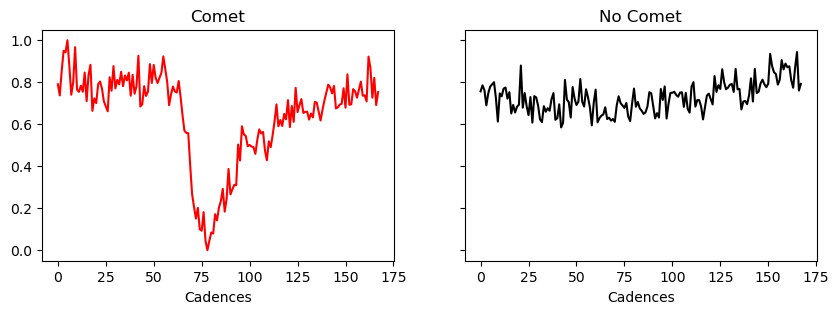

In [23]:
n = 45
ind_pc = np.where(ds.train_labels==1)[0] # Flares
ind_nc = np.where(ds.train_labels!=1)[0] # No flares

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds.train_data[ind_pc[n]], 'r')
ax1.set_title('Comet')
ax1.set_xlabel('Cadences')
ax2.plot(ds.train_data[ind_nc[n]], 'k')
ax2.set_title('No Comet')
ax2.set_xlabel('Cadences');

### Example of Exocomet Models

In [71]:
save_plots_name = f'../modelplots/{name}/'
os.makedirs(save_plots_name,exist_ok=True)


dsmodels = ds.train_data[ind_pc]
dsnomodels = ds.train_data[ind_nc]

num_sets = dsmodels.shape[0] // 100

for set_index in tqdm(range(num_sets)):
    start_index = set_index * 100
    end_index = min((set_index + 1) * 100, dsmodels.shape[0])  # Ensure not to exceed the length of the data

    # Create a new 10x10 grid of subplots for each set
    fig, axs = plt.subplots(10, 10, figsize=(20, 20))

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    # Iterate over the elements in the current set and plot each in the grid
    for i in range(start_index, end_index):
        plot_index = i % 100  # Calculate the index within the current grid
        axs[plot_index].plot(dsmodels[i, :, 0])  # Assuming you want to plot the first dimension of your array
        axs[plot_index].set_title(f"Plot {i}")  # Title for each subplot

    # Hide any remaining empty subplots
    for j in range(end_index - start_index, len(axs)):
        axs[j].axis('off')

    
    plt.tight_layout()  # Adjust layout
    plt.savefig(f'{save_plots_name}/{start_index}-{end_index}.png',dpi=200,bbox_inches='tight')
    plt.close() 
    

100%|██████████████████████████████████| 2/2 [00:23<00:00, 11.59s/it]
